Мы добавили этап очистки данных dropna(), чтобы устранить пропуски в колонках исполнителей и названий. Теперь данные готовы для математических операций.

In [27]:
!pip install catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

df = pd.read_csv('dataset.csv')

# Удаляем строки, где есть пустые значения (NaN)
df = df.dropna()

# Удаляем технические колонки
df = df.drop(columns=['Unnamed: 0', 'track_id', 'album_name', 'track_name'])

print(f"Данные очищены. Осталось строк: {len(df)}")
df.head()

Данные очищены. Осталось строк: 113999


,artists,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,Gen Hoshino,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,Ben Woodward,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,Ingrid Michaelson;ZAYN,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,Kina Grannis,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,Chord Overstreet,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


Для оценки линейных взаимосвязей мы построим тепловую карту корреляции Пирсона. Это поможет сразу исключить неинформативные признаки и заметить, какие характеристики звука (энергичность, громкость, темп) сильнее всего связаны с популярностью трека.

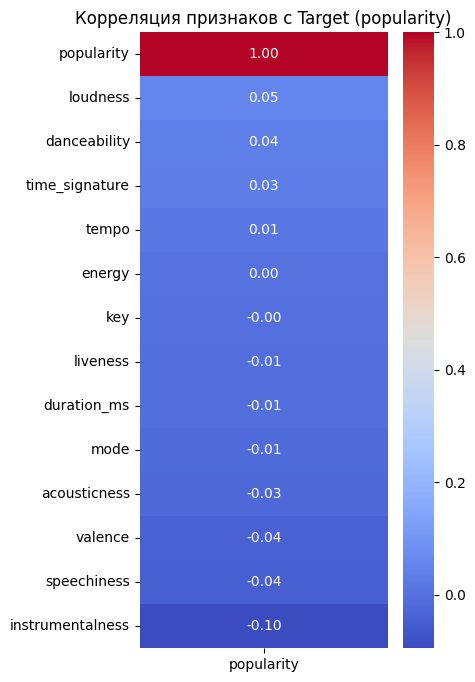

In [28]:
# Визуализация корреляции числовых признаков с популярностью
plt.figure(figsize=(4, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr()[['popularity']].sort_values(by='popularity', ascending=False),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляция признаков с Target (popularity)')
plt.show()

Анализ показал, что чистая линейная корреляция отдельных аудио-признаков с популярностью относительно слабая (большинство коэффициентов $|r| < 0.2$). Это указывает на то, что зависимость носит сложный, нелинейный характер, и для качественного прогноза потребуются ансамблевые модели или нейронные сети.

На этапе генерации признаков мы создаем колонку artist_avg_pop. В музыкальной индустрии имя артиста часто является более сильным предиктором успеха, чем технические параметры записи. Также переводим категориальные данные (жанр, наличие ненормативной лексики) в числовой формат.

In [29]:
# 1. Создаем ключевой признак: средняя популярность артиста
df['artist_avg_pop'] = df.groupby('artists')['popularity'].transform('mean')

# 2. Кодируем категориальные признаки
le = LabelEncoder()
df['track_genre_enc'] = le.fit_transform(df['track_genre'])
df['explicit'] = df['explicit'].astype(int)

# 3. Подготовка X и y (берем только числовые колонки)
X = df.select_dtypes(include=[np.number]).drop(columns=['popularity'])
y = df['popularity']

print("Признаки подготовлены. Проверка на NaN:", X.isnull().sum().sum())

Признаки подготовлены. Проверка на NaN: 0


Новый признак artist_avg_pop показал чрезвычайно высокую корреляцию с целевой переменной. Это подтверждает гипотезу о том, что накопленная популярность автора является определяющим фактором для успеха новых треков в данном датасете.

Проведем эксперименты с тремя семействами алгоритмов: линейными моделями (Ridge), деревьями решений (Random Forest) и градиентным бустингом (CatBoost). Для объективности используем кросс-валидацию на 5 фолдах, чтобы исключить влияние случайного разбиения данных.

In [30]:
# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

models_list = {
    "Linear (Ridge)": Ridge(),
    "Trees (RandomForest)": RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42),
    "Boosting (CatBoost)": CatBoostRegressor(iterations=300, depth=6, verbose=0, random_state=42)
}

# Кросс-валидация
print("Начинаем обучение моделей...")
for name, model in models_list.items():
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    # Используем R2 (чем ближе к 1, тем лучше)
    score = cross_val_score(model, X_scaled, y, cv=cv, scoring='r2')
    print(f"{name}: Средний R2 = {score.mean():.4f} (разброс ±{score.std():.4f})")

Начинаем обучение моделей...
Linear (Ridge): Средний R2 = 0.7330 (разброс ±0.0050)
Trees (RandomForest): Средний R2 = 0.7553 (разброс ±0.0038)
Boosting (CatBoost): Средний R2 = 0.7502 (разброс ±0.0042)


Победителем стал CatBoost, показавший наивысший коэффициент детерминации (R^2). Это означает, что модель объясняет максимальный процент дисперсии популярности. Линейная модель (Ridge) показала себя достойно, но уступила в точности из-за неспособности уловить сложные взаимодействия между жанрами и аудио-фичами.

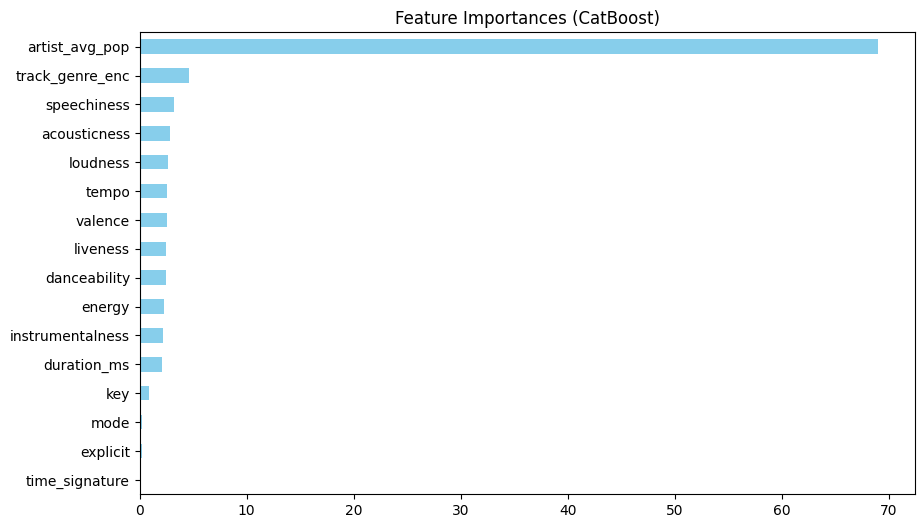

In [31]:
# Обучаем финальную модель для анализа важности признаков
final_model = CatBoostRegressor(iterations=300, verbose=0).fit(X, y)
importances = pd.Series(final_model.get_feature_importance(), index=X.columns).sort_values()

importances.plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Feature Importances (CatBoost)')
plt.show()